<a href="https://colab.research.google.com/github/nv-rliu/accelerated-networkx/blob/main/getting_started_tutorials/accelerated_networkx_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# NetworkX - Easy Graph Analytics

NetworkX is the most popular library for graph analytics available in Python, or quite possibly any language. To illustrate this, NetworkX was downloaded more than 80 million times in September of 2024 alone, which is roughly 50 times more than the next most popular graph analytics library! [*](https://en.wikipedia.org/wiki/NetworkX) NetworkX has earned this popularity from its very easy-to-use API, the wealth of documentation and examples available, the large (and friendly) community behind it, and its easy installation which requires nothing more than python.

However, NetworkX users are familiar with the tradeoff that comes with those benefits. The pure-Python implementation often results in poor performance when graph data starts to reach larger scales, limiting the usefulness of the library for many real-world problems.

# Accelerated NetworkX - Easy (and fast!) Graph Analytics

To address the performance problem, NetworkX 3.0 introduced a mechanism to dispatch algorithm calls to alternate implementations. The NetworkX Python API remains the same but NetworkX will use more capable algorithm implementations provided by one or more backends. This approach means users don't have to give up NetworkX -or even change their code- in order to take advantage of GPU performance.

# Let's Get the Environment Setup
This notebook will demonstrate NetworkX both with and without GPU acceleration provided by the `nx-cugraph` backend.

`nx-cugraph` is available as a package installable using `pip`, `conda`, and [from source](https://github.com/rapidsai/nx-cugraph).  Before importing `networkx`, lets install `nx-cugraph` so it can be registered as an available backend by NetworkX when needed.  We'll use `pip` to install.

NOTES:
* `nx-cugraph` requires a compatible NVIDIA GPU, NVIDIA CUDA, its associated drivers, and a supported OS. Details about these and other installation prerequisites can be seen [here](https://docs.rapids.ai/install#system-req).
* The `nx-cugraph` package is currently hosted by NVIDIA, therefore the `--extra-index-url` option must be used.
* `nx-cugraph` is supported on specific 11.x and 12.x CUDA versions, and the major version number must be known in order to install the correct build (this is determined automatically when using `conda`).

To find the CUDA major version on your system, run the following command:

In [1]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0


From the above output we can see that we're using CUDA 12.x so we'll be installing `nx-cugraph-cu12`. If we were using CUDA 11.x the package name would be `nx-cugraph-cu11`. We'll also be adding `https://pypi.nvidia.com` as an `--extra-index-url`:

In [2]:
!pip install nx-cugraph-cu12 --extra-index-url=https://pypi.nvidia.com

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com


Of course, we'll also be using `networkx`, which is already provided in the Colab environment. This notebook will be using features added in version 3.4, so we'll import it here to verify we have a compatible version.

In [3]:
import networkx as nx
nx.__version__

'3.4.1'

# Let's Start with Something Simple

To begin, we'll compare NetworkX results without a backend to results of the same algorithm using the `nx-cugraph` backend on a small graph.  `nx.karate_club_graph()` returns an instance of the famous example graph consisting of 34 nodes and 78 edges from Zachary's paper, described [here](https://en.wikipedia.org/wiki/Zachary%27s_karate_club).

## Betweenness Centrality
[Betweenness Centrality](https://en.wikipedia.org/wiki/Betweenness_centrality) is a graph algorithm that computes a centrality score for each node (`v`) based on how many of the shortest paths between pairs of nodes in the graph pass through `v`. A higher centrality score represents a node that "connects" other nodes in a network more than that of a node with a lower score.

First, let's create a NetworkX Graph instance of the the Karate Club graph and inspect it.

In [4]:
G = nx.karate_club_graph()
G.number_of_nodes(), G.number_of_edges()

(34, 78)

Next, let's run betweenness centrality and save the results. This should not take long since the Karate Club graph is so small.

In [5]:
%%time
nx_bc_results = nx.betweenness_centrality(G)

CPU times: user 3.16 ms, sys: 32 µs, total: 3.19 ms
Wall time: 3.19 ms


Now, let's run the same algorithm using the `nx-cugraph` backend.

There are several ways to instruct NetworkX to use a particular backend instead of the default implementation. Here we will use the `NX_CUGRAPH_AUTOCONFIG` environment variable, which was added in NetworkX version 3.4.

The following line will set the backend to "cugraph" and enable graph conversion caching.

Some notes:
* The standard convention for NetworkX backends is to name the package with a `nx-` prefix to denote they're packages intended to be used with NetworkX, but the `nx-` prefix is not included when referring to them in NetworkX API calls. Here, `nx-cugraph` is the name of the backend package and `"cugraph"` is the name NetworkX will use to refer to it.
* NetworkX supports the use of multiple backends! If a backend cannot run a particular algorithm (either because it isn't supported, doesn't support a particular option, or for some other reason), NetworkX will fall back to the default implementation.
* Many backends have their own data structures for representing the input graph, which are often optimized for that backend's implementation. Prior to running a backend algorithm, NetworkX will have the backend convert the standard NetworkX Graph instance to the backend-specific type. This conversion can be expensive, and rather than repeat it as part of each algorithm call, NetworkX can cache the conversion so it can be skipped on future calls if the graph has not changed. This caching can save significant time and improve overall performance.

In [16]:
%env NX_CUGRAPH_AUTOCONFIG=True

env: NX_CUGRAPH_AUTOCONFIG=True


In [8]:
%%time
nxcg_bc_results = nx.betweenness_centrality(G)

CPU times: user 5.25 ms, sys: 0 ns, total: 5.25 ms
Wall time: 6.07 ms


You may have noticed that using the `nx-cugraph` backend resulted in a slightly slower execution time. This is not suprising when working with a graph this small, since the overhead of converting the graph for the first time and launching the algorithm kernel on the GPU is actually significantly more than the computation time itself.  We'll see later on that this overhead is negligable when compared to the time we can save by running on the GPU when using large data.

Since we've enabled graph conversion caching, we can see that if we re-run the same call the execution time is noticeably shorter.

In [9]:
%%time
nxcg_bc_results = nx.betweenness_centrality(G)

CPU times: user 2.88 ms, sys: 0 ns, total: 2.88 ms
Wall time: 2.88 ms


Smaller graphs are easy to visualize with NetworkX's plotting utilities. The flexibility of NetworkX's `Graph` instances make it trivial to add the betweenness centrality scores back to the graph object as attributes of the nodes. This will allow us to use those values in the visualization.

In this case, we'll create new attributes for each node called "nx_bc" for the default NetworkX results, and "nxcg_bc" for the nx-cugraph results. We'll use those values to assign the color for each node and plot two graphs side-by-side. This will make it easy to visually validate that the nodes with the higher centrality scores for both implementations match and do indeed appear to be more "central" to the other nodes.

In [10]:
nx.set_node_attributes(G, nx_bc_results, "nx_bc")
nx.set_node_attributes(G, nxcg_bc_results, "nxcg_bc")

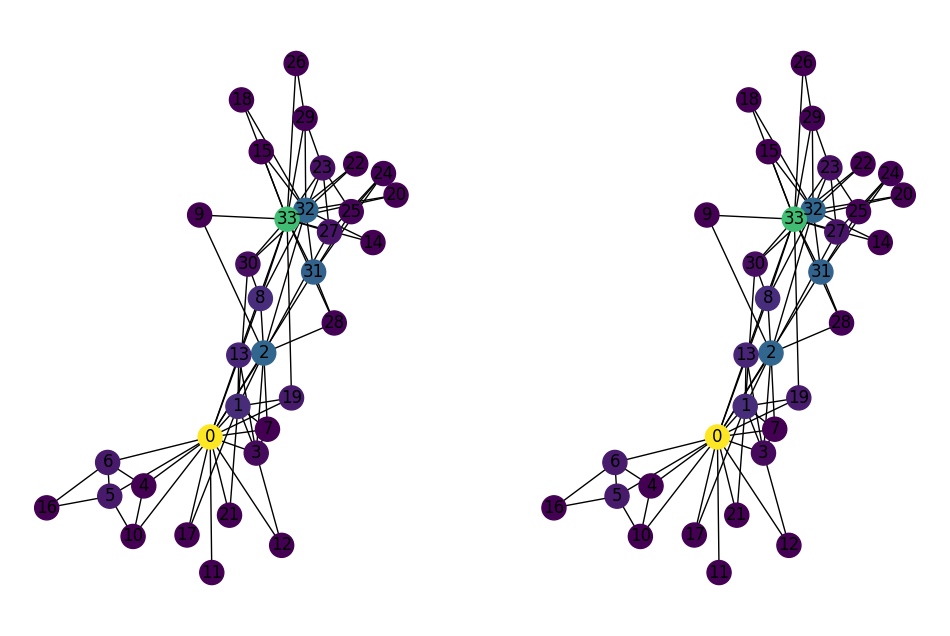

In [11]:
# Configure plot size and layout/position for each node
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [12, 8]
pos = nx.spring_layout(G)

# Assign colors for each set of betweenness centrality results
nx_colors = [G.nodes[n]["nx_bc"] for n in G.nodes()]
nxcg_colors = [G.nodes[n]["nxcg_bc"] for n in G.nodes()]

# Plot the graph and color each node corresponding to NetworkX betweenness centrality values
plt.subplot(1, 2, 1)
nx.draw(G, pos=pos, with_labels=True, node_color=nx_colors)

# Plot the graph and color each node corresponding to nx-cugraph betweenness centrality values
plt.subplot(1, 2, 2)
nx.draw(G, pos=pos, with_labels=True, node_color=nxcg_colors)

As we can see, the same two nodes (`0` and `33`) are the two most central in both graphs, followed by `2`, `31`, and `32`.

## PageRank
Another popular graph algorithm is [PageRank](https://en.wikipedia.org/wiki/PageRank). PageRank also assigns scores to each node, but these scores are based on analyzing links to every other node to determine relative "importance" within the graph.

Let's unset the environment variable so that we're using the default NetworkX implementation and run `nx.pagerank`.

In [31]:
def unset():
  import os

  if 'NX_CUGRAPH_AUTOCONFIG' in os.environ:
    del os.environ['NX_CUGRAPH_AUTOCONFIG']
  else:
    print("Already unset!")

unset()

In [20]:
%%time
nx_pr_results = nx.pagerank(G)

CPU times: user 3.98 ms, sys: 0 ns, total: 3.98 ms
Wall time: 3.99 ms


We could set `NX_CUGRAPH_AUTOCONFIG` again to use `nx-cugraph` as the backend, but instead, let's show how the `backend` keyword argument can be used to override the priority list and force a particular backend to be used.

In [21]:
%%time
nxcg_pr_results = nx.pagerank(G, backend="cugraph")

CPU times: user 1.49 s, sys: 421 ms, total: 1.91 s
Wall time: 4.53 s


Instead of plotting the graph to show that the results are identical, we'll compare them directly using the saved values from both runs.

In [22]:
sorted(nx_pr_results) == sorted(nxcg_pr_results)

True

# Working with Bigger Data

Now we'll look at a larger dataset from https://snap.stanford.edu/data/cit-Patents.html containing citations between U.S. patents granted from January 1, 1963 to December 30, 1999. The dataset represents 16.5M citations (edges) between 3.77M patents (nodes).

Data of this size starts to push the limits of the default pure-python NetworkX implementation.

Note: _the dataset is available as a compressed file from `snap.stanford.edu` and will require additional arguments to uncompress it and skip headers. The uncompressed data is available without the headers from `data.rapids.ai`. We've included code for both in the notebook below to demonstrate both approaches._

In [23]:
# The locale encoding may have been modified from the plots above, reset here to run shell commands
import locale
locale.getpreferredencoding = lambda: "UTF-8"
!wget https://snap.stanford.edu/data/cit-Patents.txt.gz  # Skip if cit-Patents.txt.gz already exists.

--2024-10-22 02:27:19--  https://snap.stanford.edu/data/cit-Patents.txt.gz
Resolving snap.stanford.edu (snap.stanford.edu)... 171.64.75.80
Connecting to snap.stanford.edu (snap.stanford.edu)|171.64.75.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 85139832 (81M) [application/x-gzip]
Saving to: ‘cit-Patents.txt.gz’

cit-Patents.txt.gz  100%[===================>]  81.20M  7.72MB/s    in 13s     

2024-10-22 02:27:33 (6.10 MB/s) - ‘cit-Patents.txt.gz’ saved [85139832/85139832]



In [ ]:
# !wget https://data.rapids.ai/cugraph/datasets/cit-Patents.csv  # Skip if cit-Patents.csv already exists.

# df = pd.read_csv("cit-Patents.csv",
#                 sep=" ",
#                 names=["src", "dst"],
#                 dtype="int32",
# )

We are running inside a Colab environment, which will have `cudf` preinstalled. This is a GPU accelerated DataFrame library, and it can be used to speed up the reading of large files. I will call `%load_ext` to enable `cudf.pandas`

In [24]:
%load_ext cudf.pandas
import pandas as pd

In [25]:
%%time
df = pd.read_csv("cit-Patents.txt.gz",
                 compression="gzip",
                 skiprows=4,
                 sep="\t",
                 names=["src", "dst"],
                 dtype="int32",
)

CPU times: user 1.64 s, sys: 392 ms, total: 2.03 s
Wall time: 2.24 s


In [27]:
%%time
G = nx.from_pandas_edgelist(df, source="src", target="dst")
G.number_of_nodes(), G.number_of_edges()

CPU times: user 59.6 s, sys: 3.58 s, total: 1min 3s
Wall time: 1min 3s


(3774768, 16518948)

By default, `nx.betweenness_centrality` will perform an all-pairs shortest path analysis when determining the centrality scores for each node. However, due to the large size of this graph, determining the shortest path for all pairs of nodes is not feasible. Instead, we'll use the parameter `k` to limit the number of shortest path computations used for determining the centrality scores (at the expense of accuracy). As we'll see when using a dataset this size with `nx.betweenness_centrality`, we have to limit `k` to `1` which is not practical but is sufficient here for demonstration purposes (since anything larger than `1` will result in many minutes of execution time).

In [28]:
%%time
bc_results = nx.betweenness_centrality(G, k=1)

CPU times: user 1min 12s, sys: 2.26 s, total: 1min 14s
Wall time: 1min 14s


Now we'll configure NetworkX to use the `nx-cugraph` backend (again, using the naming convention that drops the package name's `nx-` prefix) and run the same call. Because this is a Graph that `nx-cugraph` hasn't seen before, the runtime includes the time it took to internally convert and cache a GPU-based graph.

In [32]:
%env NX_CUGRAPH_AUTOCONFIG=True

env: NX_CUGRAPH_AUTOCONFIG=True


In [36]:
%%time
bc_results = nx.betweenness_centrality(G, k=1, backend="cugraph")

/usr/local/lib/python3.10/dist-packages/networkx/utils/backends.py:1777: UserWarning: Note: conversions to backend graphs are saved to cache (`G.__networkx_cache__` on the original graph) by default.

This warning means the cached graph is being used for the 'cugraph' backend in the call to betweenness_centrality.

For the cache to be consistent (i.e., correct), the input graph must not have been manually mutated since the cached graph was created. Examples of manually mutating the graph data structures resulting in an inconsistent cache include:

    >>> G[u][v][key] = val

and

    >>> for u, v, d in G.edges(data=True):
    ...     d[key] = val

Using methods such as `G.add_edge(u, v, weight=val)` will correctly clear the cache to keep it consistent. You may also use `G.__networkx_cache__.clear()` to manually clear the cache, or set `G.__networkx_cache__` to None to disable caching for G. Enable or disable caching globally via `nx.config.cache_converted_graphs` config.

To disable th

CPU times: user 1.87 s, sys: 200 ms, total: 2.07 s
Wall time: 2.02 s


Let's run betweenness centrality again with a more useful number of samples by setting `k=100`.

In [ ]:
%%time
bc_results = nx.betweenness_centrality(G, k=100)

CPU times: user 27.2 s, sys: 1.9 s, total: 29.2 s
Wall time: 29.3 s


Let's also run pagerank on the same dataset to compare.

In [ ]:
nx.config.backend_priority = []

In [ ]:
%%time
nx_pr_results = nx.pagerank(G)

CPU times: user 1min 55s, sys: 5.68 s, total: 2min 1s
Wall time: 2min 3s


In [ ]:
%%time
nxcg_pr_results = nx.pagerank(G, backend="cugraph")

CPU times: user 1.41 s, sys: 278 ms, total: 1.69 s
Wall time: 1.68 s


In [ ]:
sorted(nx_pr_results) == sorted(nxcg_pr_results)

True

---
<i>
Each user is responsible for checking the content of datasets and the applicable licenses and determining if suitable for the intended use.
<i>
<br>
<br>
<i>
Information on the U.S. Patent Citation Network dataset used in this notebook is as follows:
<br>Authors: Jure Leskovec and Andrej Krevl
<br>Title: SNAP Datasets, Stanford Large Network Dataset Collection
<br>URL: http://snap.stanford.edu/data
<br>Date: June 2014
</i>
